# Expected Output

In [2]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve
import pickle
import os

import matplotlib as mpl
mpl.rc('image', cmap='gray')

In [3]:
base = 'C:/Users/ritvik/Desktop/JPLProject/data/GoogleEarthEngineData/Sentinel2/roi/'

In [4]:
training_data = pickle.load(open('stored_training_data.p', 'rb'))
regions_of_interest = list(training_data.keys())

In [5]:
wetland_type = 'Marsh'

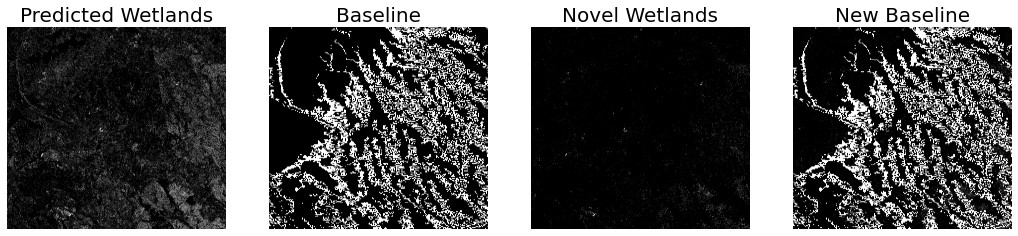

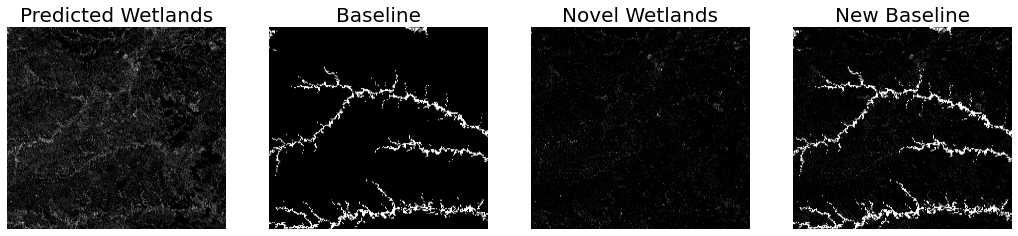

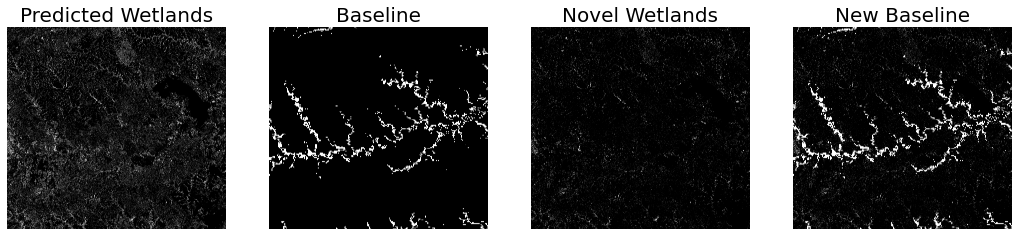

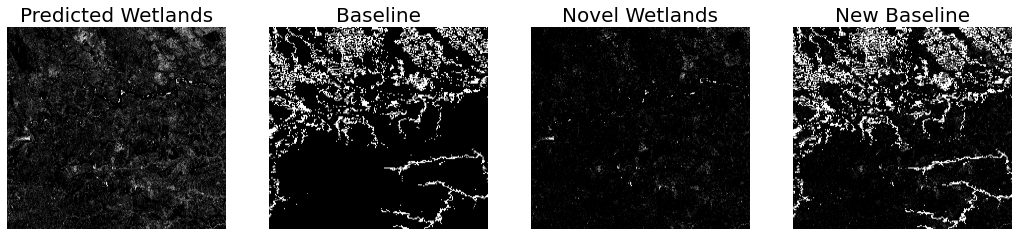

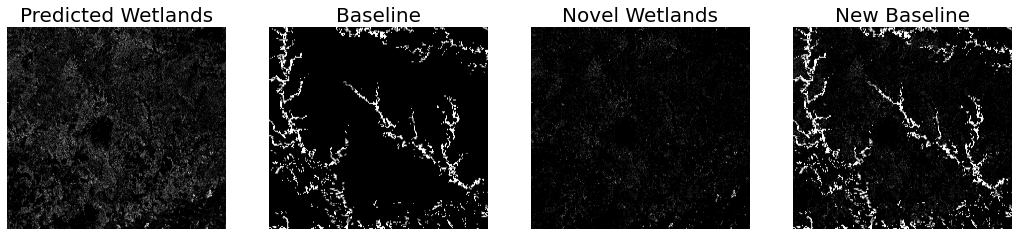

In [6]:
for folder in regions_of_interest:
    
    #get names of predicted wetlands and original baseline rasters
    predicted_baseline_fname = '%s%s/corrected_%s.tiff'%(base, folder, folder)
    baseline_fname = '%s%s/baseline_%s_%s.tiff'%(base, folder, wetland_type, folder)

    #open the map
    ds = gdal.Open(predicted_baseline_fname, gdal.GA_ReadOnly)
    arr = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    ds = None
    
    
    #get the corresponding baseline array
    ds = gdal.Open(baseline_fname, gdal.GA_ReadOnly)
    baseline_arr = ds.ReadAsArray()
    scale = arr.shape[0] // baseline_arr.shape[0]
    baseline_arr = np.repeat(np.repeat(baseline_arr, scale, axis=0), scale, axis=1)
    ds = None

    #get the data mask
    data_mask = (baseline_arr != -1)&(arr != -1)
    
    #only show predicted areas which are 90th percentile and above (confident wetland predictions)
    thresh = np.percentile(arr[arr!=-1], 90)

    plt.figure(figsize=(18,6))
    
    #plot these confident wetlands
    plt.subplot(1,4,1)
    plt.imshow(arr > thresh)
    plt.title('Predicted Wetlands', fontsize=20)
    plt.axis('off')
    
    #plot the baseline
    plt.subplot(1,4,2)
    plt.imshow(baseline_arr == 1)
    plt.title('Baseline', fontsize=20)
    plt.axis('off')

    #difference between predicted and baseline
    diff = (arr - baseline_arr > thresh)
    
    #convolve this difference with low pass filter to remove noise
    size = 3
    kernel = np.ones((size,size)) / size**2
    b = convolve(diff, kernel, mode='same')
    diff[b < thresh] = 0
    diff[~data_mask] = 0

    #show places where predicted shows much more likely areas then baseline to ID "novel" wetlands in that area
    plt.subplot(1,4,3)
    plt.imshow(diff)
    plt.title('Novel Wetlands', fontsize=20)
    plt.axis('off')
    
    #create a new baseline by adding the original baseline to the differences (novel wetlands)
    new_baseline = baseline_arr + diff
    shown_baseline = new_baseline.copy()
    shown_baseline[new_baseline == -1] = 0
    plt.subplot(1,4,4)
    plt.imshow(shown_baseline)
    plt.title('New Baseline', fontsize=20)
    plt.axis('off')

    #save the new baseline to the respective sub-directory
    new_baseline_fname = '%s%s/new_baseline_%s_%s.tiff'%(base, folder, wetland_type, folder)
    ds = np_array_to_raster(new_baseline_fname, new_baseline, gt, no_data=-1, nband=1, gdal_data_type=gdal.GDT_Float64)
    ds = None
    
    plt.show()